In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pytorch_models
import imp
import torchaudio as ta
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
from pytorch_models import *
import librosa
import librosa.display
import pytorch_models as pm
import optuna

imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]


loading data base from ./drum_dbs/dk_data ./drum_dbs/dk_data.dill


In [3]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


label
clap             115
hihat_closed     185
hihat_open       230
kick             614
rim              102
snare            700
synth_noise     8000
tom_high         144
tom_low          165
tom_mid          122
Name: path, dtype: int64


In [4]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
ds[0]

{'signal': tensor([ 0.0004, -0.0012,  0.0390,  ...,  0.0000,  0.0000,  0.0000]),
 'label': tensor(0),
 'path': './drum_dbs/dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav',
 'drum_type': 'tom_high'}

{'signal': tensor([ 0.0000e+00, -3.0518e-05, -3.0518e-05,  ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00]), 'label': tensor(1), 'path': './drum_dbs/dk_data/synth_noise/HYJZ-3239-4.wav', 'drum_type': 'synth_noise'}
torch.Size([1, 30, 20]) tensor([3.7909e-07, 5.0741e-07, 7.7629e-07, 1.3659e-06, 2.7968e-06, 1.9363e-05,
        8.4242e-04, 2.3242e-03, 2.3834e-04, 2.2146e-05, 8.9346e-06, 5.1134e-06,
        3.3995e-06, 2.4830e-06, 1.9094e-06, 1.5283e-06, 1.2478e-06, 1.0442e-06,
        8.9443e-07, 7.8342e-07, 8.1766e-07, 2.9007e-05, 1.5309e-04, 1.0328e-04,
        8.5892e-07, 1.5714e-06, 4.7181e-05, 1.3926e-05, 5.4379e-07, 5.0643e-07])


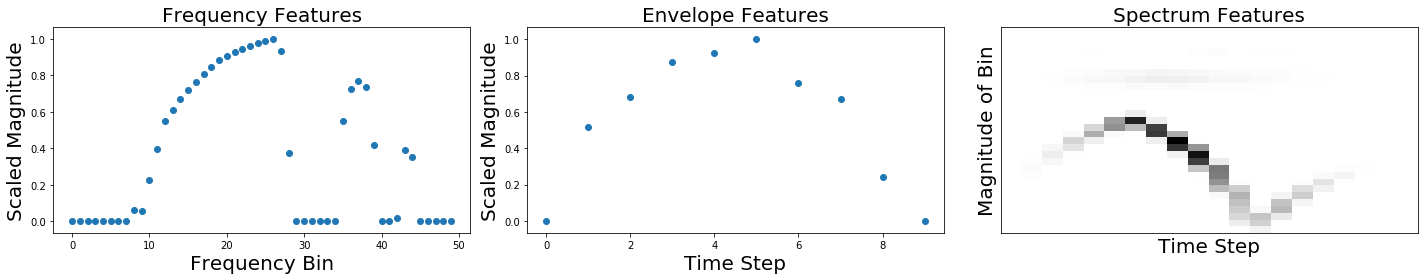

In [5]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20,amp_to_power=False):
        self.amp_to_power=amp_to_power
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
        self.amps=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]
print(sample)
for i, tsfrm in enumerate(tfList):

    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,ft[0,:,0])
        sf=ft.detach().numpy()[0]
        ft=ft.detach().numpy()[0]
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
# print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER

In [6]:
class AE_Linear_1H(nn.Module):
    def __init__(self,compression_dim=64,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = self.dropout(torch.relu(activation))
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Linear_2H(nn.Module):
    def __init__(self,compression_dim=8,dropout_rate=0.5,input_shape=[30,20]):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.encoder_hidden_layer1 = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_hidden_layer2 = nn.Linear(
            in_features=128, out_features=32
        )
        self.encoder_output_layer = nn.Linear(
            in_features=32, out_features=compression_dim
        )
        self.decoder_hidden_layer1 = nn.Linear(
            in_features=compression_dim, out_features=32
        )
        self.decoder_hidden_layer2 = nn.Linear(
            in_features=32, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )
    def forward(self, features):
        activation = self.encoder_hidden_layer1(features)
        activation = self.dropout(torch.relu(activation))
        h1_out = self.encoder_hidden_layer2(activation)
        h1_out = self.dropout(torch.relu(h1_out))
        code = self.encoder_output_layer(h1_out)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer1(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_hidden_layer2(activation)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    
class AE_Conv(nn.Module):
    def __init__(self,input_shape,compression_dim,dropout_rate,num_channels=5):
        super(AE_Conv, self).__init__()
        self.W=input_shape[0]
        self.H=input_shape[1]

        self.dropout = nn.Dropout(dropout_rate)
        self.Encoder_Conv= nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=num_channels, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.encoder_output_layer = nn.Linear(
            in_features=(self.H//2 * self.W//2) * 8, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=self.W*self.H)
        
    def forward(self, features):
        features=features.reshape([-1,1,self.W,self.H])
        activation = self.Encoder_Conv(features)
        activation = self.dropout(torch.relu(activation))
        activation = activation.reshape(activation.size(0), -1)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = self.dropout(torch.relu(activation))
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [7]:
compression_dim=8
spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.50,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)

train_synthless=train[train["label_num"]==0]
test_synthless=test[test["label_num"]==0]
spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=pt)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)


/home/asalimi/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
def objective(trial):

    #hyper params
    learning_rate = trial.suggest_uniform('Learning Rate', 1e-4,1e-1)
    dropout_rate = trial.suggest_discrete_uniform('Dropout Rate', 0,0.5,0.1)
    latent_size = trial.suggest_categorical('Latent Size',[4, 16, 64])
    optimizer_type = trial.suggest_categorical('Optimizer', ['Adam', 'SGD'])
    FREQ_BINS = trial.suggest_categorical('Frequency Bins', [10, 30, 60])
    TIME_STEPS = trial.suggest_categorical('Time Steps', [10, 20])
    hidden_layers= trial.suggest_int('Hidden Layers', 1, 2)
    l2=trial.suggest_loguniform('L2 Regularization', 1e-6,1e-1)
    model_type=trial.suggest_categorical('Model Type', ['CNN', 'FC'])

    num_channels=5

    spec_dimension=FREQ_BINS*TIME_STEPS

    criterion=nn.MSELoss()
    
    #make model
    if hidden_layers==1:
        model = AE_Linear_1H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    else:
        model = AE_Linear_2H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
    if model_type=="CNN":
        model = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=num_channels).to(device)
        
    if optimizer_type=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
    elif optimizer_type=="SGD":
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=l2)
    #make dataloader 
    ptTune=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])
    spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=ptTune)
    spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=16,shuffle=True, num_workers=8)
    spec_data_test_nosynth = audioDataset(test_synthless,".",task="dvn", transform=ptTune)
    spec_test_nosynth_loader= DataLoader(spec_data_test_nosynth, batch_size=16,shuffle=True, num_workers=8)
    #train
    epochs=4
    for epoch in range(epochs):
        loss = 0
        for batch_features in spec_train_nosynth_loader:
            batch_features=batch_features["feats"]
            batch_features = batch_features.view(-1, spec_dimension).to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(spec_train_nosynth_loader)
        test_loss=0
        with torch.no_grad():
            for batch_features in spec_test_nosynth_loader:
                batch_features=batch_features["feats"]
                batch_features = batch_features.view(-1, spec_dimension).to(device)
                outputs = model(batch_features)
                temp_loss = criterion(outputs, batch_features)
                test_loss += temp_loss.item()
        test_loss = test_loss / len(spec_test_nosynth_loader) 
        trial.report(test_loss, epoch)   
        if epoch%2==0:
            if trial.should_prune():
                raise optuna.TrialPruned()
        print("epoch : {}/{}, loss = {:.6f}, test_loss = {:.6f}".format(epoch, epochs, loss,test_loss))
    return test_loss
study = optuna.create_study(study_name='study_1',sampler=optuna.samplers.RandomSampler(), 
                            pruner=optuna.pruners.HyperbandPruner(), storage='sqlite:///optuna_median.db',load_if_exists=True)
study.optimize(objective, n_trials=100)

[I 2020-09-15 13:24:54,820] A new study created with name: study_1


epoch : 0/4, loss = 0.007685, test_loss = 0.006799
epoch : 1/4, loss = 0.006178, test_loss = 0.006072
epoch : 2/4, loss = 0.005704, test_loss = 0.005940
epoch : 3/4, loss = 0.005655, test_loss = 0.005880


[I 2020-09-15 13:25:12,443] Finished trial#0 with value: 0.005879989925872635 with parameters: {'Learning Rate': 0.04633957288489894, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.00022214504767489684, 'Model Type': 'CNN'}. Best is trial#0 with value: 0.005879989925872635.


epoch : 0/4, loss = 0.002441, test_loss = 0.002462
epoch : 1/4, loss = 0.002329, test_loss = 0.002471
epoch : 2/4, loss = 0.002355, test_loss = 0.002426
epoch : 3/4, loss = 0.002346, test_loss = 0.002472


[I 2020-09-15 13:25:41,265] Finished trial#1 with value: 0.0024719670528193585 with parameters: {'Learning Rate': 0.030507494218883397, 'Dropout Rate': 0.5, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.0009039890458283983, 'Model Type': 'CNN'}. Best is trial#1 with value: 0.0024719670528193585.


epoch : 0/4, loss = 0.003140, test_loss = 0.002913
epoch : 1/4, loss = 0.002811, test_loss = 0.003108


[I 2020-09-15 13:26:01,753] Setting status of trial#2 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.007613, test_loss = 0.006468
epoch : 1/4, loss = 0.005835, test_loss = 0.005903


[I 2020-09-15 13:26:15,046] Setting status of trial#3 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.003132, test_loss = 0.002873
epoch : 1/4, loss = 0.002701, test_loss = 0.002807


[I 2020-09-15 13:26:36,722] Setting status of trial#4 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.009307, test_loss = 0.008874
epoch : 1/4, loss = 0.008848, test_loss = 0.009025


[I 2020-09-15 13:26:48,252] Setting status of trial#5 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.002371, test_loss = 0.002429
epoch : 1/4, loss = 0.002286, test_loss = 0.002388
epoch : 2/4, loss = 0.002292, test_loss = 0.002397
epoch : 3/4, loss = 0.002304, test_loss = 0.002403


[I 2020-09-15 13:27:17,355] Finished trial#6 with value: 0.0024031549786544732 with parameters: {'Learning Rate': 0.0244159856401081, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.075409003334307e-05, 'Model Type': 'CNN'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.009281, test_loss = 0.008773
epoch : 1/4, loss = 0.008576, test_loss = 0.008808


[I 2020-09-15 13:27:37,054] Setting status of trial#7 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.004366, test_loss = 0.004057
epoch : 1/4, loss = 0.003933, test_loss = 0.004028


[I 2020-09-15 13:27:52,911] Setting status of trial#8 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.010313, test_loss = 0.009585
epoch : 1/4, loss = 0.008923, test_loss = 0.008391
epoch : 2/4, loss = 0.007170, test_loss = 0.006753
epoch : 3/4, loss = 0.006258, test_loss = 0.006328


[I 2020-09-15 13:28:19,520] Finished trial#9 with value: 0.006327786652774022 with parameters: {'Learning Rate': 0.04629432206813644, 'Dropout Rate': 0.2, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 2.802655535287162e-06, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.003640, test_loss = 0.003607
epoch : 1/4, loss = 0.003388, test_loss = 0.003400
epoch : 2/4, loss = 0.003214, test_loss = 0.003253
epoch : 3/4, loss = 0.003080, test_loss = 0.003132


[I 2020-09-15 13:28:48,649] Finished trial#10 with value: 0.0031322317396139574 with parameters: {'Learning Rate': 0.03971699607974676, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 6.002573370507835e-05, 'Model Type': 'CNN'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.006955, test_loss = 0.006576
epoch : 1/4, loss = 0.006087, test_loss = 0.006228
epoch : 2/4, loss = 0.005903, test_loss = 0.006137
epoch : 3/4, loss = 0.005816, test_loss = 0.006034


[I 2020-09-15 13:29:06,160] Finished trial#11 with value: 0.006033526000415755 with parameters: {'Learning Rate': 0.07634178138592708, 'Dropout Rate': 0.2, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 1.4980136375044707e-06, 'Model Type': 'CNN'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.003374, test_loss = 0.002837
epoch : 1/4, loss = 0.002715, test_loss = 0.002826


[I 2020-09-15 13:29:27,763] Setting status of trial#12 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.011217, test_loss = 0.004444
epoch : 1/4, loss = 0.004206, test_loss = 0.004235


[I 2020-09-15 13:29:43,694] Setting status of trial#13 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005971, test_loss = 0.006020
epoch : 1/4, loss = 0.005827, test_loss = 0.006015


[I 2020-09-15 13:29:56,738] Setting status of trial#14 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.007305, test_loss = 0.007237
epoch : 1/4, loss = 0.007028, test_loss = 0.007312


[I 2020-09-15 13:30:09,929] Setting status of trial#15 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005739, test_loss = 0.005646
epoch : 1/4, loss = 0.005497, test_loss = 0.005869
epoch : 2/4, loss = 0.005470, test_loss = 0.005868
epoch : 3/4, loss = 0.005494, test_loss = 0.005759


[I 2020-09-15 13:30:27,114] Finished trial#16 with value: 0.005758977460523916 with parameters: {'Learning Rate': 0.07951623828529203, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.00031234861577260863, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.003535, test_loss = 0.003377
epoch : 1/4, loss = 0.003155, test_loss = 0.004008


[I 2020-09-15 13:30:42,748] Setting status of trial#17 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.012187, test_loss = 0.011932
epoch : 1/4, loss = 0.011281, test_loss = 0.011114


[I 2020-09-15 13:31:02,675] Setting status of trial#18 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.012670, test_loss = 0.009986
epoch : 1/4, loss = 0.009394, test_loss = 0.009358


[I 2020-09-15 13:31:14,023] Setting status of trial#19 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.009410, test_loss = 0.008590
epoch : 1/4, loss = 0.007808, test_loss = 0.007522
epoch : 2/4, loss = 0.007048, test_loss = 0.007060
epoch : 3/4, loss = 0.006626, test_loss = 0.006709


[I 2020-09-15 13:31:40,559] Finished trial#20 with value: 0.006708566067941688 with parameters: {'Learning Rate': 0.03243105577798813, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00023956117613134834, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.009647, test_loss = 0.007164
epoch : 1/4, loss = 0.006424, test_loss = 0.006450


[I 2020-09-15 13:31:53,445] Setting status of trial#21 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.006401, test_loss = 0.006308
epoch : 1/4, loss = 0.006065, test_loss = 0.006303


[I 2020-09-15 13:32:06,263] Setting status of trial#22 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005922, test_loss = 0.005330
epoch : 1/4, loss = 0.004910, test_loss = 0.004738
epoch : 2/4, loss = 0.004489, test_loss = 0.004482
epoch : 3/4, loss = 0.004268, test_loss = 0.004322


[I 2020-09-15 13:32:27,574] Finished trial#23 with value: 0.004322397255187703 with parameters: {'Learning Rate': 0.06479790069228863, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.0009297867044010104, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.003940, test_loss = 0.003731
epoch : 1/4, loss = 0.003634, test_loss = 0.003727
epoch : 2/4, loss = 0.003604, test_loss = 0.003728
epoch : 3/4, loss = 0.003604, test_loss = 0.003719


[I 2020-09-15 13:32:48,690] Finished trial#24 with value: 0.0037187222183707193 with parameters: {'Learning Rate': 0.0018658416818130843, 'Dropout Rate': 0.4, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.0001711859479056543, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.013421, test_loss = 0.013398
epoch : 1/4, loss = 0.013636, test_loss = 0.013846


[I 2020-09-15 13:33:00,318] Setting status of trial#25 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.012101, test_loss = 0.010597
epoch : 1/4, loss = 0.010393, test_loss = 0.010574
epoch : 2/4, loss = 0.010600, test_loss = 0.010513
epoch : 3/4, loss = 0.010272, test_loss = 0.010661


[I 2020-09-15 13:33:15,955] Finished trial#26 with value: 0.010660814694003077 with parameters: {'Learning Rate': 0.05593628187185701, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 1.1678160604275393e-06, 'Model Type': 'CNN'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.008406, test_loss = 0.005986
epoch : 1/4, loss = 0.004840, test_loss = 0.004489


[I 2020-09-15 13:33:36,711] Setting status of trial#27 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.011783, test_loss = 0.009752
epoch : 1/4, loss = 0.009349, test_loss = 0.009516


[I 2020-09-15 13:33:48,521] Setting status of trial#28 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.004031, test_loss = 0.003983
epoch : 1/4, loss = 0.003888, test_loss = 0.004012
epoch : 2/4, loss = 0.003843, test_loss = 0.004065
epoch : 3/4, loss = 0.003857, test_loss = 0.004112


[I 2020-09-15 13:34:10,007] Finished trial#29 with value: 0.004111647517797914 with parameters: {'Learning Rate': 0.0928121266132625, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.0028284647522457016, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.009558, test_loss = 0.009681
epoch : 1/4, loss = 0.009162, test_loss = 0.009344


[I 2020-09-15 13:34:21,610] Setting status of trial#30 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.019915, test_loss = 0.019014
epoch : 1/4, loss = 0.018060, test_loss = 0.017292


[I 2020-09-15 13:34:37,351] Setting status of trial#31 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.006958, test_loss = 0.005135
epoch : 1/4, loss = 0.004384, test_loss = 0.004065
epoch : 2/4, loss = 0.003741, test_loss = 0.003639
epoch : 3/4, loss = 0.003378, test_loss = 0.003395


[I 2020-09-15 13:35:06,812] Finished trial#32 with value: 0.0033954781656329695 with parameters: {'Learning Rate': 0.07167952885257582, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.831470060412663e-06, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.005443, test_loss = 0.005285
epoch : 1/4, loss = 0.004821, test_loss = 0.004805


[I 2020-09-15 13:35:27,438] Setting status of trial#33 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.003814, test_loss = 0.003825
epoch : 1/4, loss = 0.003698, test_loss = 0.003885
epoch : 2/4, loss = 0.003737, test_loss = 0.003787
epoch : 3/4, loss = 0.003725, test_loss = 0.003843


[I 2020-09-15 13:35:48,673] Finished trial#34 with value: 0.003842870141631244 with parameters: {'Learning Rate': 0.08277951770155054, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.00015050776066239326, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.008320, test_loss = 0.007140
epoch : 1/4, loss = 0.006907, test_loss = 0.007149
epoch : 2/4, loss = 0.006921, test_loss = 0.007156
epoch : 3/4, loss = 0.006909, test_loss = 0.007158


[I 2020-09-15 13:36:06,171] Finished trial#35 with value: 0.0071582759894128585 with parameters: {'Learning Rate': 0.07822106708643975, 'Dropout Rate': 0.1, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 1.1045452320007337e-06, 'Model Type': 'CNN'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.008629, test_loss = 0.008048
epoch : 1/4, loss = 0.007264, test_loss = 0.007142


[I 2020-09-15 13:36:17,827] Setting status of trial#36 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005906, test_loss = 0.006009
epoch : 1/4, loss = 0.005677, test_loss = 0.005870


[I 2020-09-15 13:36:37,626] Setting status of trial#37 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.013219, test_loss = 0.013273
epoch : 1/4, loss = 0.013167, test_loss = 0.013261
epoch : 2/4, loss = 0.013286, test_loss = 0.013985
epoch : 3/4, loss = 0.013278, test_loss = 0.013316


[I 2020-09-15 13:36:53,172] Finished trial#38 with value: 0.013315531311909089 with parameters: {'Learning Rate': 0.09277548581731376, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.07897916498960639, 'Model Type': 'CNN'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.004946, test_loss = 0.004859
epoch : 1/4, loss = 0.004086, test_loss = 0.004321
epoch : 2/4, loss = 0.004100, test_loss = 0.004505
epoch : 3/4, loss = 0.004049, test_loss = 0.004230


[I 2020-09-15 13:37:19,683] Finished trial#39 with value: 0.004230028506041177 with parameters: {'Learning Rate': 0.05011970115883236, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.00018943099407416736, 'Model Type': 'FC'}. Best is trial#6 with value: 0.0024031549786544732.


epoch : 0/4, loss = 0.004817, test_loss = 0.003604
epoch : 1/4, loss = 0.002646, test_loss = 0.002165
epoch : 2/4, loss = 0.001916, test_loss = 0.001838
epoch : 3/4, loss = 0.001631, test_loss = 0.001729


[I 2020-09-15 13:37:46,017] Finished trial#40 with value: 0.0017289507369561172 with parameters: {'Learning Rate': 0.004238912656469461, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.6467454129545388e-06, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.008763, test_loss = 0.006772
epoch : 1/4, loss = 0.006389, test_loss = 0.006613


[I 2020-09-15 13:37:58,943] Setting status of trial#41 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.003631, test_loss = 0.003708
epoch : 1/4, loss = 0.003536, test_loss = 0.003758
epoch : 2/4, loss = 0.003541, test_loss = 0.003748
epoch : 3/4, loss = 0.003543, test_loss = 0.003714


[I 2020-09-15 13:38:26,699] Finished trial#42 with value: 0.003714236301823041 with parameters: {'Learning Rate': 0.04190069122167564, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0008483111554625711, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.013158, test_loss = 0.009773
epoch : 1/4, loss = 0.009189, test_loss = 0.009348
epoch : 2/4, loss = 0.009039, test_loss = 0.009167
epoch : 3/4, loss = 0.009060, test_loss = 0.009197


[I 2020-09-15 13:38:42,213] Finished trial#43 with value: 0.009196693964956983 with parameters: {'Learning Rate': 0.04565896161404025, 'Dropout Rate': 0.4, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 10, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.005672678235365808, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.005325, test_loss = 0.005166
epoch : 1/4, loss = 0.004820, test_loss = 0.004824


[I 2020-09-15 13:39:02,964] Setting status of trial#44 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.008245, test_loss = 0.008637
epoch : 1/4, loss = 0.008252, test_loss = 0.008371


[I 2020-09-15 13:39:23,363] Setting status of trial#45 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.004813, test_loss = 0.004515
epoch : 1/4, loss = 0.004364, test_loss = 0.004507
epoch : 2/4, loss = 0.004355, test_loss = 0.004485
epoch : 3/4, loss = 0.004482, test_loss = 0.004513


[I 2020-09-15 13:39:44,505] Finished trial#46 with value: 0.004513488207767541 with parameters: {'Learning Rate': 0.07420427616167083, 'Dropout Rate': 0.2, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.05246031636715549, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.009629, test_loss = 0.007399
epoch : 1/4, loss = 0.006807, test_loss = 0.006989


[I 2020-09-15 13:39:57,541] Setting status of trial#47 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.011721, test_loss = 0.010670
epoch : 1/4, loss = 0.009650, test_loss = 0.008904
epoch : 2/4, loss = 0.008183, test_loss = 0.007698
epoch : 3/4, loss = 0.007143, test_loss = 0.006797


[I 2020-09-15 13:40:26,565] Finished trial#48 with value: 0.006797318674019865 with parameters: {'Learning Rate': 0.012810755807408798, 'Dropout Rate': 0.4, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.00014386050447578596, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.002735, test_loss = 0.002502
epoch : 1/4, loss = 0.002394, test_loss = 0.002462
epoch : 2/4, loss = 0.002398, test_loss = 0.002557
epoch : 3/4, loss = 0.002421, test_loss = 0.002526


[I 2020-09-15 13:40:55,476] Finished trial#49 with value: 0.002526282927499631 with parameters: {'Learning Rate': 0.06929329087330503, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.0012572662188850715, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.007972, test_loss = 0.006713
epoch : 1/4, loss = 0.006305, test_loss = 0.005877
epoch : 2/4, loss = 0.005494, test_loss = 0.006436
epoch : 3/4, loss = 0.005498, test_loss = 0.005708


[I 2020-09-15 13:41:12,824] Finished trial#50 with value: 0.005708390120039317 with parameters: {'Learning Rate': 0.09410397624378077, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.00036112948294935083, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.004388, test_loss = 0.004049
epoch : 1/4, loss = 0.003671, test_loss = 0.003565
epoch : 2/4, loss = 0.003282, test_loss = 0.003263
epoch : 3/4, loss = 0.003075, test_loss = 0.003067


[I 2020-09-15 13:41:41,626] Finished trial#51 with value: 0.0030665069384299016 with parameters: {'Learning Rate': 0.06560321054673998, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.0002632529079914289, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.009850, test_loss = 0.010068
epoch : 1/4, loss = 0.009721, test_loss = 0.009773


[I 2020-09-15 13:41:53,275] Setting status of trial#52 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.006248, test_loss = 0.005626
epoch : 1/4, loss = 0.005009, test_loss = 0.004856
epoch : 2/4, loss = 0.004472, test_loss = 0.004511
epoch : 3/4, loss = 0.004279, test_loss = 0.004320


[I 2020-09-15 13:42:20,746] Finished trial#53 with value: 0.004319519808239027 with parameters: {'Learning Rate': 0.07788955733312762, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 4.459599702319406e-06, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.002203, test_loss = 0.002337
epoch : 1/4, loss = 0.002121, test_loss = 0.002117
epoch : 2/4, loss = 0.002083, test_loss = 0.002242
epoch : 3/4, loss = 0.002129, test_loss = 0.002149


[I 2020-09-15 13:42:49,905] Finished trial#54 with value: 0.002149103005649522 with parameters: {'Learning Rate': 0.044833615618054865, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 3.687023232664146e-05, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.006510, test_loss = 0.005602
epoch : 1/4, loss = 0.005238, test_loss = 0.005288


[I 2020-09-15 13:43:03,013] Setting status of trial#55 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.014952, test_loss = 0.014789
epoch : 1/4, loss = 0.014589, test_loss = 0.014735
epoch : 2/4, loss = 0.014502, test_loss = 0.014721
epoch : 3/4, loss = 0.014490, test_loss = 0.014680


[I 2020-09-15 13:43:18,472] Finished trial#56 with value: 0.014679637850841155 with parameters: {'Learning Rate': 0.09459630609390461, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 10, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 2.87677921967855e-06, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.004118, test_loss = 0.004108
epoch : 1/4, loss = 0.004024, test_loss = 0.004116


[I 2020-09-15 13:43:34,416] Setting status of trial#57 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005004, test_loss = 0.004256
epoch : 1/4, loss = 0.003789, test_loss = 0.003618
epoch : 2/4, loss = 0.003358, test_loss = 0.003314
epoch : 3/4, loss = 0.003129, test_loss = 0.003132


[I 2020-09-15 13:44:03,450] Finished trial#58 with value: 0.0031319406368090093 with parameters: {'Learning Rate': 0.07402118114835697, 'Dropout Rate': 0.1, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 6.368595738829929e-06, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.003979, test_loss = 0.003849
epoch : 1/4, loss = 0.003563, test_loss = 0.003516
epoch : 2/4, loss = 0.003306, test_loss = 0.003308
epoch : 3/4, loss = 0.003135, test_loss = 0.003163


[I 2020-09-15 13:44:32,387] Finished trial#59 with value: 0.0031627330054352816 with parameters: {'Learning Rate': 0.07146764153369793, 'Dropout Rate': 0.1, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 2.557707276984763e-06, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.007196, test_loss = 0.007175
epoch : 1/4, loss = 0.006773, test_loss = 0.006767
epoch : 2/4, loss = 0.006419, test_loss = 0.006441
epoch : 3/4, loss = 0.006159, test_loss = 0.006188


[I 2020-09-15 13:44:59,855] Finished trial#60 with value: 0.0061884340012093655 with parameters: {'Learning Rate': 0.012565884979159716, 'Dropout Rate': 0.5, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.00019468972562386693, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.013862, test_loss = 0.010607
epoch : 1/4, loss = 0.008940, test_loss = 0.008027
epoch : 2/4, loss = 0.007246, test_loss = 0.007067
epoch : 3/4, loss = 0.006575, test_loss = 0.006726


[I 2020-09-15 13:45:17,263] Finished trial#61 with value: 0.006725704951866253 with parameters: {'Learning Rate': 0.012086572626750688, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.012307025314019287, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.004107, test_loss = 0.004179
epoch : 1/4, loss = 0.004071, test_loss = 0.004185


[I 2020-09-15 13:45:33,020] Setting status of trial#62 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.004766, test_loss = 0.003708
epoch : 1/4, loss = 0.003559, test_loss = 0.003823
epoch : 2/4, loss = 0.003547, test_loss = 0.003780
epoch : 3/4, loss = 0.003558, test_loss = 0.003954


[I 2020-09-15 13:46:00,740] Finished trial#63 with value: 0.0039537574630230665 with parameters: {'Learning Rate': 0.0742829446744817, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.0006102834677983657, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.002379, test_loss = 0.002432
epoch : 1/4, loss = 0.002323, test_loss = 0.002417
epoch : 2/4, loss = 0.002309, test_loss = 0.002447
epoch : 3/4, loss = 0.002359, test_loss = 0.002446


[I 2020-09-15 13:46:30,068] Finished trial#64 with value: 0.002445549260497697 with parameters: {'Learning Rate': 0.022711291123236013, 'Dropout Rate': 0.1, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.0005364031273907507, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.007062, test_loss = 0.006449
epoch : 1/4, loss = 0.006121, test_loss = 0.006435
epoch : 2/4, loss = 0.006069, test_loss = 0.006352
epoch : 3/4, loss = 0.006097, test_loss = 0.006383


[I 2020-09-15 13:46:47,475] Finished trial#65 with value: 0.006382791476475226 with parameters: {'Learning Rate': 0.09057118883874457, 'Dropout Rate': 0.0, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 1.6398108449177916e-05, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.004738, test_loss = 0.003927
epoch : 1/4, loss = 0.003903, test_loss = 0.003997


[I 2020-09-15 13:47:03,809] Setting status of trial#66 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.011958, test_loss = 0.009491
epoch : 1/4, loss = 0.008947, test_loss = 0.008646


[I 2020-09-15 13:47:15,123] Setting status of trial#67 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.004783, test_loss = 0.004370
epoch : 1/4, loss = 0.004165, test_loss = 0.004090


[I 2020-09-15 13:47:35,888] Setting status of trial#68 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.009900, test_loss = 0.010052
epoch : 1/4, loss = 0.009954, test_loss = 0.009887


[I 2020-09-15 13:47:47,449] Setting status of trial#69 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.002535, test_loss = 0.002526
epoch : 1/4, loss = 0.002395, test_loss = 0.002553
epoch : 2/4, loss = 0.002398, test_loss = 0.002522
epoch : 3/4, loss = 0.002396, test_loss = 0.002545


[I 2020-09-15 13:48:16,337] Finished trial#70 with value: 0.002545493149915962 with parameters: {'Learning Rate': 0.061755180159315054, 'Dropout Rate': 0.4, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.3166783302601952e-05, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.010822, test_loss = 0.010278
epoch : 1/4, loss = 0.009274, test_loss = 0.008995


[I 2020-09-15 13:48:27,919] Setting status of trial#71 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.014185, test_loss = 0.012753
epoch : 1/4, loss = 0.011999, test_loss = 0.011829
epoch : 2/4, loss = 0.011546, test_loss = 0.011500
epoch : 3/4, loss = 0.011276, test_loss = 0.011493


[I 2020-09-15 13:48:43,337] Finished trial#72 with value: 0.011492869867062246 with parameters: {'Learning Rate': 0.02098807731144159, 'Dropout Rate': 0.5, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 10, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 0.028203025813651333, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.014028, test_loss = 0.012764
epoch : 1/4, loss = 0.012600, test_loss = 0.012546


[I 2020-09-15 13:48:54,880] Setting status of trial#73 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005640, test_loss = 0.005672
epoch : 1/4, loss = 0.005599, test_loss = 0.005795


[I 2020-09-15 13:49:08,054] Setting status of trial#74 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.006821, test_loss = 0.004541
epoch : 1/4, loss = 0.004370, test_loss = 0.004499


[I 2020-09-15 13:49:23,906] Setting status of trial#75 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.004838, test_loss = 0.004334
epoch : 1/4, loss = 0.004012, test_loss = 0.004179
epoch : 2/4, loss = 0.003852, test_loss = 0.004129
epoch : 3/4, loss = 0.003818, test_loss = 0.003990


[I 2020-09-15 13:49:51,593] Finished trial#76 with value: 0.003989844874013215 with parameters: {'Learning Rate': 0.09827846470048399, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 4.796144723534623e-05, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.007973, test_loss = 0.006891
epoch : 1/4, loss = 0.006460, test_loss = 0.006663
epoch : 2/4, loss = 0.006537, test_loss = 0.006619
epoch : 3/4, loss = 0.006347, test_loss = 0.006546


[I 2020-09-15 13:50:18,647] Finished trial#77 with value: 0.006546378821587643 with parameters: {'Learning Rate': 0.08988840446460547, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 2.61759821676798e-06, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.006118, test_loss = 0.004111
epoch : 1/4, loss = 0.003940, test_loss = 0.004050
epoch : 2/4, loss = 0.003976, test_loss = 0.004035
epoch : 3/4, loss = 0.003931, test_loss = 0.004032


[I 2020-09-15 13:50:39,733] Finished trial#78 with value: 0.004032165340676501 with parameters: {'Learning Rate': 0.06693313357823383, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.00046603059267033846, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.009121, test_loss = 0.008088
epoch : 1/4, loss = 0.007252, test_loss = 0.007145
epoch : 2/4, loss = 0.006692, test_loss = 0.006806
epoch : 3/4, loss = 0.006436, test_loss = 0.006636


[I 2020-09-15 13:50:57,122] Finished trial#79 with value: 0.006636368387655632 with parameters: {'Learning Rate': 0.04647873675291021, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 30, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 2.7527799610806048e-05, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.004322, test_loss = 0.003817
epoch : 1/4, loss = 0.003392, test_loss = 0.003236
epoch : 2/4, loss = 0.003000, test_loss = 0.002968
epoch : 3/4, loss = 0.002768, test_loss = 0.002816


[I 2020-09-15 13:51:26,033] Finished trial#80 with value: 0.0028162696681967056 with parameters: {'Learning Rate': 0.08182029909087177, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.4066340292701248e-06, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.007833, test_loss = 0.005067
epoch : 1/4, loss = 0.004610, test_loss = 0.004536
epoch : 2/4, loss = 0.004335, test_loss = 0.004395
epoch : 3/4, loss = 0.004261, test_loss = 0.004319


[I 2020-09-15 13:51:47,107] Finished trial#81 with value: 0.004318552909771333 with parameters: {'Learning Rate': 0.08634732475893898, 'Dropout Rate': 0.30000000000000004, 'Latent Size': 4, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 1, 'L2 Regularization': 4.585848768680514e-05, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.003448, test_loss = 0.003276
epoch : 1/4, loss = 0.002955, test_loss = 0.002919
epoch : 2/4, loss = 0.002741, test_loss = 0.002777
epoch : 3/4, loss = 0.002633, test_loss = 0.002717


[I 2020-09-15 13:52:16,407] Finished trial#82 with value: 0.002716551177719658 with parameters: {'Learning Rate': 0.08220943825342761, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.002386454426804946, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.002439, test_loss = 0.002485
epoch : 1/4, loss = 0.002390, test_loss = 0.002476
epoch : 2/4, loss = 0.002384, test_loss = 0.002478
epoch : 3/4, loss = 0.002359, test_loss = 0.002534


[I 2020-09-15 13:52:45,936] Finished trial#83 with value: 0.0025343818832314698 with parameters: {'Learning Rate': 0.036347944600499144, 'Dropout Rate': 0.1, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.001125625544479838, 'Model Type': 'FC'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.020059, test_loss = 0.015637
epoch : 1/4, loss = 0.015580, test_loss = 0.015582


[I 2020-09-15 13:52:57,401] Setting status of trial#84 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005414, test_loss = 0.005173
epoch : 1/4, loss = 0.004822, test_loss = 0.004795


[I 2020-09-15 13:53:13,428] Setting status of trial#85 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.007304, test_loss = 0.005034
epoch : 1/4, loss = 0.004508, test_loss = 0.004414


[I 2020-09-15 13:53:29,198] Setting status of trial#86 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.002995, test_loss = 0.002756
epoch : 1/4, loss = 0.002615, test_loss = 0.002747
epoch : 2/4, loss = 0.002630, test_loss = 0.002761
epoch : 3/4, loss = 0.002609, test_loss = 0.002755


[I 2020-09-15 13:53:58,397] Finished trial#87 with value: 0.0027550872953331753 with parameters: {'Learning Rate': 0.0722848721385622, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.010011929240931455, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.005483, test_loss = 0.004495
epoch : 1/4, loss = 0.004124, test_loss = 0.004632
epoch : 2/4, loss = 0.003831, test_loss = 0.003895
epoch : 3/4, loss = 0.002957, test_loss = 0.003020


[I 2020-09-15 13:54:25,188] Finished trial#88 with value: 0.003019653065633532 with parameters: {'Learning Rate': 0.046670720198932696, 'Dropout Rate': 0.0, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 0.00018750403138962865, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.006581, test_loss = 0.004281
epoch : 1/4, loss = 0.003912, test_loss = 0.004058


[I 2020-09-15 13:54:45,893] Setting status of trial#89 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.013106, test_loss = 0.009734
epoch : 1/4, loss = 0.009674, test_loss = 0.009866
epoch : 2/4, loss = 0.009562, test_loss = 0.009601
epoch : 3/4, loss = 0.009102, test_loss = 0.009058


[I 2020-09-15 13:55:01,377] Finished trial#90 with value: 0.009057926923363796 with parameters: {'Learning Rate': 0.0567861803542144, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 10, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 0.0015510501947574003, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.006012, test_loss = 0.004152
epoch : 1/4, loss = 0.004009, test_loss = 0.004176
epoch : 2/4, loss = 0.004024, test_loss = 0.004327
epoch : 3/4, loss = 0.003693, test_loss = 0.003782


[I 2020-09-15 13:55:29,056] Finished trial#91 with value: 0.0037817658944609197 with parameters: {'Learning Rate': 0.05774220522908608, 'Dropout Rate': 0.0, 'Latent Size': 4, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.0002778236777765246, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.008264, test_loss = 0.006084
epoch : 1/4, loss = 0.005473, test_loss = 0.005645


[I 2020-09-15 13:55:42,232] Setting status of trial#92 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.010256, test_loss = 0.010251
epoch : 1/4, loss = 0.010102, test_loss = 0.010830


[I 2020-09-15 13:55:53,726] Setting status of trial#93 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.013863, test_loss = 0.011206
epoch : 1/4, loss = 0.010405, test_loss = 0.010192


[I 2020-09-15 13:56:05,258] Setting status of trial#94 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.007088, test_loss = 0.004559
epoch : 1/4, loss = 0.004225, test_loss = 0.004212


[I 2020-09-15 13:56:25,924] Setting status of trial#95 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.005455, test_loss = 0.005389
epoch : 1/4, loss = 0.005154, test_loss = 0.005157
epoch : 2/4, loss = 0.004966, test_loss = 0.004983
epoch : 3/4, loss = 0.004783, test_loss = 0.004860


[I 2020-09-15 13:56:47,276] Finished trial#96 with value: 0.004859731771756668 with parameters: {'Learning Rate': 0.02726572423978673, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'SGD', 'Frequency Bins': 60, 'Time Steps': 10, 'Hidden Layers': 2, 'L2 Regularization': 3.0493806940119736e-05, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.007669, test_loss = 0.007729
epoch : 1/4, loss = 0.007663, test_loss = 0.007711


[I 2020-09-15 13:57:08,982] Setting status of trial#97 as TrialState.PRUNED. 


epoch : 0/4, loss = 0.004357, test_loss = 0.004505
epoch : 1/4, loss = 0.004322, test_loss = 0.004523
epoch : 2/4, loss = 0.004363, test_loss = 0.004496
epoch : 3/4, loss = 0.004295, test_loss = 0.004517


[I 2020-09-15 13:57:36,638] Finished trial#98 with value: 0.00451710939759741 with parameters: {'Learning Rate': 0.004132048352405128, 'Dropout Rate': 0.4, 'Latent Size': 64, 'Optimizer': 'Adam', 'Frequency Bins': 30, 'Time Steps': 20, 'Hidden Layers': 1, 'L2 Regularization': 0.02954321207933394, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


epoch : 0/4, loss = 0.002888, test_loss = 0.002729
epoch : 1/4, loss = 0.002649, test_loss = 0.002755
epoch : 2/4, loss = 0.002717, test_loss = 0.002741
epoch : 3/4, loss = 0.002620, test_loss = 0.002755


[I 2020-09-15 13:58:05,771] Finished trial#99 with value: 0.0027554193716118665 with parameters: {'Learning Rate': 0.06761653927164371, 'Dropout Rate': 0.4, 'Latent Size': 16, 'Optimizer': 'Adam', 'Frequency Bins': 60, 'Time Steps': 20, 'Hidden Layers': 2, 'L2 Regularization': 1.61146526725673e-05, 'Model Type': 'CNN'}. Best is trial#40 with value: 0.0017289507369561172.


In [17]:
AE_Linear_1H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate)

AE_Linear_1H(
  (dropout): Dropout(p=0.5, inplace=False)
  (encoder_hidden_layer): Linear(in_features=600, out_features=128, bias=True)
  (encoder_output_layer): Linear(in_features=128, out_features=8, bias=True)
  (decoder_hidden_layer): Linear(in_features=8, out_features=128, bias=True)
  (decoder_output_layer): Linear(in_features=128, out_features=600, bias=True)
)

In [13]:
from torchsummary import summary
from torchviz import make_dot, make_dot_from_trace
#optimized params
learning_rate = 0.0011451089315356296
dropout_rate = 0.5
latent_size = 8
FREQ_BINS = 30
TIME_STEPS = 20
hidden_layers = 2
l2 = 3.2473701348597023e-06

model = AE_Conv(input_shape=[FREQ_BINS,TIME_STEPS],compression_dim=latent_size,dropout_rate=dropout_rate,num_channels=5).to(device)
# model = AE_Linear_1H(input_shape=spec_dimension,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)
# model = AE_Linear_2H(input_shape=FREQ_BINS*TIME_STEPS,compression_dim=latent_size,dropout_rate=dropout_rate).to(device)

dataiter=iter(spec_test_loader)
#does it work?
xy=dataiter.next()
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images=xy["feats"].detach()[0:1].reshape([FREQ_BINS*TIME_STEPS]).to(device)

summary(model,images.shape)

make_dot(model(images), params=dict(model.named_parameters()))

NameError: name 'spec_test_loader' is not defined

In [14]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_Dropout Rate,params_Frequency Bins,params_Hidden Layers,params_L2 Regularization,params_Latent Size,params_Learning Rate,params_Model Type,params_Optimizer,params_Time Steps,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,system_attrs_completed_rung_3,system_attrs_fail_reason,state
0,0,NaN,2020-07-19 23:44:47.488514,NaT,NaT,0.1,60.0,2.0,0.011836,16.0,0.076707,CNN,SGD,10.0,NaN,NaN,NaN,NaN,NaN,RUNNING
1,1,0.004806,2020-07-19 23:45:12.358015,2020-07-19 23:47:41.014338,00:02:28.656323,0.2,30.0,1.0,0.096801,64.0,0.074591,FC,SGD,20.0,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.003859,2020-07-19 23:47:41.043024,2020-07-19 23:50:07.245773,00:02:26.202749,0.2,30.0,2.0,0.000012,4.0,0.013977,FC,Adam,20.0,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.006900,2020-07-19 23:50:07.270084,2020-07-19 23:51:43.623728,00:01:36.353644,0.4,30.0,1.0,0.029560,4.0,0.053458,CNN,Adam,10.0,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.003954,2020-07-19 23:51:43.648375,2020-07-19 23:53:39.791822,00:01:56.143447,0.4,60.0,2.0,0.000001,16.0,0.042069,FC,SGD,10.0,NaN,NaN,NaN,NaN,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,647,0.007335,2020-07-22 02:04:23.593977,2020-07-22 02:04:53.234266,00:00:29.640289,0.0,30.0,2.0,0.059851,4.0,0.062219,CNN,Adam,10.0,0.007335,NaN,NaN,NaN,NaN,PRUNED
648,648,0.006327,2020-07-22 02:04:53.391752,2020-07-22 02:05:22.971342,00:00:29.579590,0.5,30.0,2.0,0.000001,64.0,0.034023,FC,SGD,10.0,0.006327,NaN,NaN,NaN,NaN,PRUNED
649,649,0.011782,2020-07-22 02:05:23.133426,2020-07-22 02:05:39.353421,00:00:16.219995,0.5,10.0,1.0,0.000015,4.0,0.016447,FC,Adam,10.0,0.011782,NaN,NaN,NaN,NaN,PRUNED
650,650,0.006013,2020-07-22 02:05:39.510486,2020-07-22 02:05:57.269154,00:00:17.758668,0.0,30.0,2.0,0.000096,64.0,0.090374,CNN,SGD,10.0,0.006013,NaN,NaN,NaN,NaN,PRUNED


In [23]:
import joblib
joblib.dump(study, 'study2.pkl')
study2 = joblib.load('study2.pkl')
print('Best trial until now:')
print(' Value: ', study2.best_trial.value)
print(' Params: ')
for key, value in study2.best_trial.params.items():
    print(f'    {key}: {value}')

Best trial until now:
 Value:  0.0007111432947567664
 Params: 
    Dropout Rate: 0.5
    Frequency Bins: 30
    Hidden Layers: 2
    L2 Regularization: 3.2473701348597023e-06
    Latent Size: 64
    Learning Rate: 0.0011451089315356296
    Model Type: CNN
    Optimizer: Adam
    Time Steps: 20
